In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

In [3]:
content_path = "style_transfer/images/louvre.jpg"
style_path = "raw-images/img_1_scaled.jpg"

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

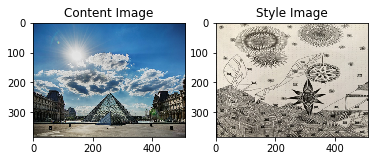

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [13]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [16]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [17]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.05260698
    max:  18663.846
    mean:  716.5511

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  101244.81
    mean:  16386.727

   block3_conv1
    shape:  (1, 256, 256)
    min:  2.381863
    max:  316676.25
    mean:  13781.922

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5011678.5
    mean:  190671.11

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  112765.54
    mean:  1622.9032

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1099.3307
    mean:  14.535644


In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [20]:
image = tf.Variable(content_image)

In [21]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [22]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
style_weight=1e-2
content_weight=1e4
total_variation_weight=1e8

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [25]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [26]:
@tf.function()
def train_step(image, regularize=True):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        if regularize:
            loss += total_variation_weight*total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

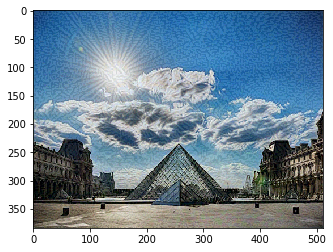

In [27]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

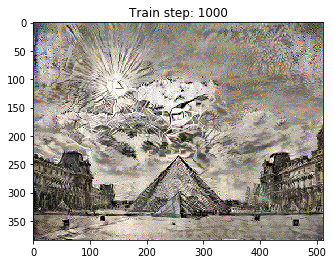

Total time: 3743.8


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))